In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from voting_mechanism_design.agents.quorum_badgeholder import QuorumBadgeholder, QuorumBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.threshold_and_aggregate import ThresholdAndAggregate
from voting_mechanism_design.sim import RoundSimulation

import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import defaultdict
from tqdm import tqdm

In [3]:
# Round design variables
total_funds = 100
min_vote = 0
max_vote = 16

In [4]:
# create badgeholder population
n = 10
badgeholder_list = []
for ii in range(n):
    badgeholder_id = ii
    agent = QuorumBadgeholder(
        badgeholder_id=badgeholder_id,
        total_funds=total_funds,
        min_vote=min_vote,  
        max_vote=max_vote,
        # TODO: these should be random variables
        laziness=1,
        expertise=1,
        coi_factor=0
    )
    badgeholder_list.append(agent)

badgeholders = QuorumBadgeholderPopulation()
badgeholders.add_badgeholders(badgeholder_list)

#print(len(badgeholders.badgeholders))

10


In [5]:
# create projects
N = 50
projects = []
for ii in range(N):
    project_id = ii
    project = Project(
        project_id=project_id,
        true_impact=1,  # TODO: this should be a random variable
        owner_id=None,  # used for COI modeling
    )
    projects.append(project)
project_population = ProjectPopulation()
project_population.add_projects(projects)

#print(project_population.num_projects)

50


In [6]:
# instantiate a funding model
fund_distribution_model = ThresholdAndAggregate()

In [17]:
badgeholders.reset_all()  # Call this before each simulation run dont think this is important anymore but im leaving it in

# create and run a simulation
simulation_obj = RoundSimulation(
    badgeholder_population=badgeholders,
    projects=project_population,
    funding_design=fund_distribution_model,
)

projects = project_population.get_projects()

simulation_obj.run(cast_votes_kwargs={'projects': projects})


In [ ]:
####Getting metrics
def count_projects_meeting_quorum(project_vote_counts, quorum):
    return sum(1 for votes in project_vote_counts.values() if votes >= quorum)

#Get votes 
all_votes = simulation_obj.badgeholder_population.get_all_votes()
project_vote_counts = defaultdict(int) # initialize dictionary to count votes
for vote in all_votes: #aggregating votes
    project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0


#Placeholders
quorum_vec = list(np.arange(1, 26))
project_pass_vec = []

#Counting projects meeting the variable quorum
for q in quorum_vec:
    num_projects_meeting_quorum = count_projects_meeting_quorum(project_vote_counts, q)
    project_pass_vec.append(num_projects_meeting_quorum)

# Plot the results
plt.figure()
plt.plot(quorum_vec, project_pass_vec)
plt.xlabel('Quorum')
plt.ylabel('Num Projects > Quorum')
plt.title('Effect of Quorum on the Number of Funded Projects \n Total Projects = 50')
plt.show()

In [23]:
####Same thing but with multiple simulation and more similar to original code 

#Placeholders
quorum_vec = list(np.arange(1, 26))
project_pass_vec = []

for q in quorum_vec: #Alternitavely we could just have the simulation outside the loop for efficiecy
    #Configuring & runnning Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Counting votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Count projects meeting the quorum
    num_projects_meeting_quorum = count_projects_meeting_quorum(project_vote_counts, q)
    project_pass_vec.append(num_projects_meeting_quorum)

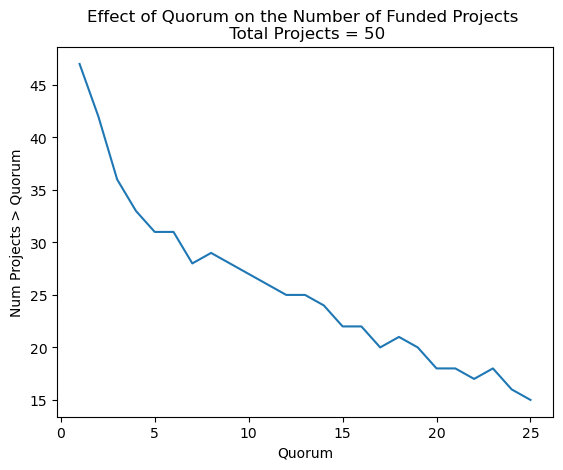

In [24]:
# Plot the results
plt.figure()
plt.plot(quorum_vec, project_pass_vec)
plt.xlabel('Quorum')
plt.ylabel('Num Projects > Quorum')
plt.title('Effect of Quorum on the Number of Funded Projects \n Total Projects = 50')
plt.show()

In [13]:
#####Graph 2

score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this 
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []

for score_fn, q in sim_configs:
    # Configuring & running Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        project.token_amount = score
        project_scores.append(score)
    
    # Store results
    pass_results.append({
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

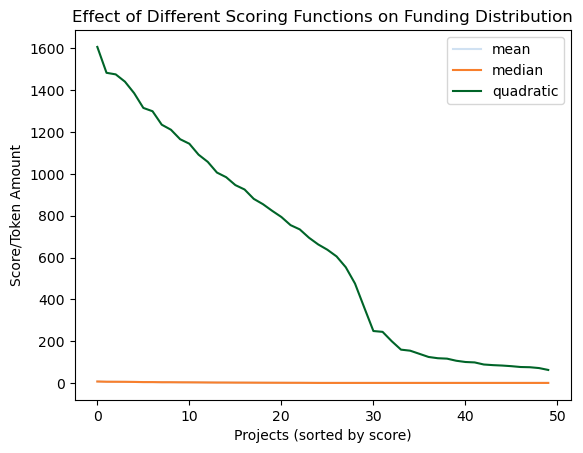

In [16]:
# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()

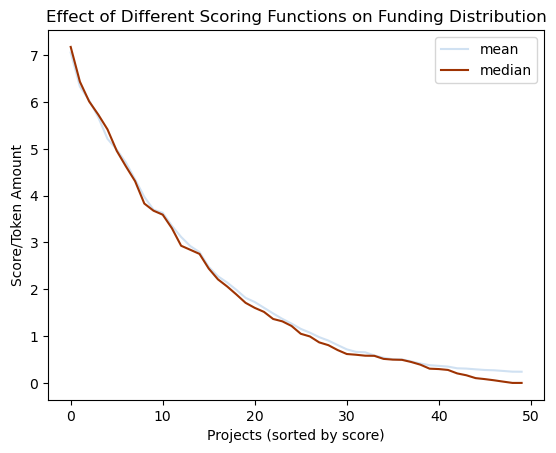

In [39]:
# Define scoring functions and quorum values
score_fns = ['mean', 'median']#, 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []

# Run simulations for different scoring functions
for score_fn, q in sim_configs:
    # Configuring & running Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        project.token_amount = score
        project_scores.append(score)
    
    # Store results
    pass_results.append({
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.93it/s]

Project 0 (mean): 7.060768978730262
Project 1 (mean): 1.0757748486718854
Project 2 (mean): 0.973135240339407
Project 3 (mean): 0.8998499381021557
Project 4 (mean): 0.809141067399385
Project 5 (mean): 0.7178372083670675
Project 6 (mean): 0.6624278762777805
Project 7 (mean): 0.6546707555063659
Project 8 (mean): 0.5871311921664303
Project 9 (mean): 0.5330762111413925
Project 10 (mean): 0.507837255098989
Project 11 (mean): 0.4614557597079582
Project 12 (mean): 0.3119001496355852
Project 13 (mean): 0.4157702099723622
Project 14 (mean): 0.3781088569558303
Project 15 (mean): 0.3472292367301007
Project 16 (mean): 0.30694030586651616
Project 17 (mean): 0.2692859985004485
Project 18 (mean): 0.28888595025243957
Project 19 (mean): 0.23829236559086764
Project 20 (mean): 0.24174623822540534
Project 21 (mean): 0.2559054648928186
Project 22 (mean): 0.2756309013254811
Project 23 (mean): 1.1524672670066562
Project 24 (mean): 1.2676855965951113
Project 25 (mean): 1.362978965943143
Project 26 (mean): 1.48

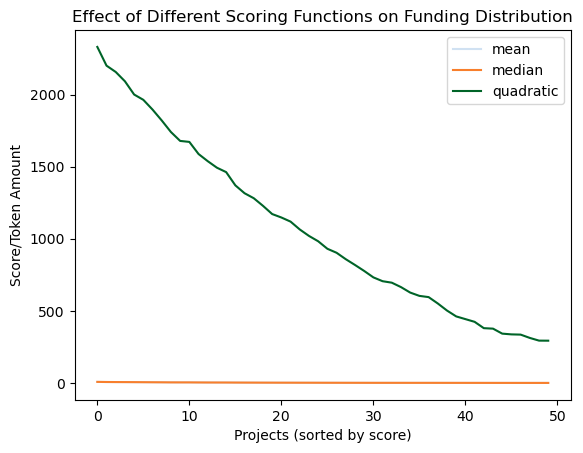

In [40]:
# Define scoring functions and quorum values
score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []

# Run simulations for different scoring functions
for score_fn, q in tqdm(sim_configs):
    # Configuring & running Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        project.token_amount = score
        project_scores.append(score)
        print(f"Project {project.project_id} ({score_fn}): {score}")  # Debugging line
    
    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.98it/s]


Project 0 votes: [11.661751217862601, 3.092277666805863, 12.001650346778868, 13.360866209569014, 11.944657602466398, 8.884124952662868, 12.564895992216742, 9.104947464550591, 3.5659083998384435, 9.935763311935165, 3.495405961485107, 3.0013712613332424, 9.201028929922218, 6.437144736899284, 12.757264278510261, 6.171145741203176, 1.2477888264416341, 2.463166388215035, 1.9539114019685326, 7.537414483645497, 10.90938577204241, 4.273238811720784, 8.40873205198581, 9.130787178594947, 12.61491901835504, 12.167525391300291, 4.699358264954412, 9.264845213899116, 2.3054703015976523, 6.747751433464591, 8.703775342057408, 7.218331156080692, 10.131798130255474, 1.9717502030514145, 6.063384008990802, 1.567290554078842, 12.385965513340185, 10.89448754177905, 2.6925289613852734, 2.9792825097367746, 12.306299651743386, 8.98231519257703, 4.762393238630801, 3.6278139565076843, 7.685645534994052, 10.45836035168445, 12.80036257415329, 4.398038809121958, 3.996017049534917, 1.183395723651421, 1.6975860451329

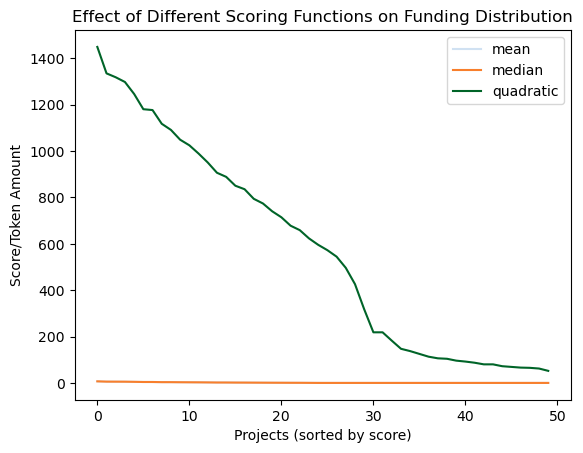

In [11]:
# Define scoring functions and quorum values
score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []

# Run simulations for different scoring functions
for score_fn, q in tqdm(sim_configs):
    # Configuring & running Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        print(f"Project {project.project_id} votes: {votes}")  # Debugging line for votes
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        project.token_amount = score
        project_scores.append(score)
        print(f"Project {project.project_id} ({score_fn}): {score}")  # Debugging line for scores
    
    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()
